# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we focus on the EDA of the $\mathrm{SU}(2)$ WZW model.

In [1]:
%load_ext autoreload
%autoreload 2

## Load the Dataset

We load the tidy dataset and prepare for the EDA by dropping duplicates and looking at its properties:

In [2]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/data_wzw.csv')
df.describe()

,k,exp_re,exp_im,weight,j,m,type,level_2_re,level_2_im,level_3_re,...,level_6_re,level_6_im,level_7_re,level_7_im,level_8_re,level_8_im,level_9_re,level_9_im,level_10_re,level_10_im
count,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,...,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000
mean,6.777381,0.038664,-0.001853,0.904315,1.971429,0.000000,3.890476,-0.077024,-0.005670,-0.079294,...,-0.011237,-0.001987,-0.003376,-0.014919,0.075769,-0.010940,0.069030,0.009722,-0.008013,0.006753
std,1.314858,0.594829,0.298647,0.588936,1.263905,1.576801,0.455165,2.614227,0.234921,2.648262,...,1.384471,0.368500,1.436868,0.443906,1.518934,0.471528,1.578406,0.623249,1.722916,0.657285
min,2.000000,-1.519671,-0.930605,0.000000,0.000000,-4.000000,2.000000,-26.284377,-1.867961,-26.284377,...,-10.978029,-2.287981,-11.445648,-3.646223,-13.721069,-4.023181,-14.249796,-6.650984,-24.994666,-7.174097
25%,6.000000,-0.437426,0.000000,0.416667,1.000000,-1.000000,4.000000,-0.570279,0.000000,-0.601505,...,-0.530362,0.000000,-0.535451,0.000000,-0.494487,0.000000,-0.482390,0.000000,-0.485126,0.000000
50%,7.000000,0.000000,0.000000,0.972222,2.000000,0.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008034,0.000000,0.006125,0.000000,0.000000,0.000000
75%,8.000000,0.500705,0.000000,1.333333,3.000000,1.000000,4.000000,0.586592,0.000000,0.619976,...,0.536852,0.000000,0.556819,0.000000,0.597575,0.000000,0.589435,0.000000,0.506648,0.000000
max,8.000000,1.414214,0.930605,2.000000,4.000000,4.000000,4.000000,35.385221,1.867961,35.385221,...,10.978029,2.287981,11.445648,3.646223,18.673134,4.023181,20.051284,6.683011,15.315423,7.187127


## Exploratory Data Analysis

As a first step in the EDA we first look at the tidy dataset and study some aggregate statistics:

In [3]:
# divide into levels and other variables for visualisation
df_lev = df.filter(regex='^level_\d*_.*')
df_oth = df.filter(regex='^(?!level).*')

In [4]:
df_lev_summary = df_lev.agg({'max', 'min', 'sum', 'mean', 'std'})

# normalize the input over rows
df_lev_summary_norm = df_lev_summary.abs().max(axis=1)
df_lev_summary_norm = df_lev_summary.div(df_lev_summary_norm, axis='index')
df_lev_summary_norm.transpose().to_csv('./data/lev_summary_norm.csv')

df_lev_summary

,level_2_re,level_2_im,level_3_re,level_3_im,level_4_re,level_4_im,level_5_re,level_5_im,level_6_re,level_6_im,level_7_re,level_7_im,level_8_re,level_8_im,level_9_re,level_9_im,level_10_re,level_10_im
mean,-0.077024,-0.005670,-0.079294,-0.009452,0.089836,-0.001553,0.078986,0.003396,-0.011237,-0.001987,-0.003376,-0.014919,0.075769,-0.010940,0.069030,0.009722,-0.008013,0.006753
std,2.614227,0.234921,2.648262,0.371899,1.286826,0.352832,1.317507,0.353773,1.384471,0.368500,1.436868,0.443906,1.518934,0.471528,1.578406,0.623249,1.722916,0.657285
sum,-129.400279,-9.525292,-133.214652,-15.878558,150.924236,-2.608309,132.696033,5.705360,-18.877472,-3.338268,-5.671341,-25.063620,127.291377,-18.379071,115.970086,16.332544,-13.461804,11.345453
max,35.385221,1.867961,35.385221,1.736677,11.673646,1.930349,11.673646,2.005075,10.978029,2.287981,11.445648,3.646223,18.673134,4.023181,20.051284,6.683011,15.315423,7.187127
min,-26.284377,-1.867961,-26.284377,-1.969113,-8.757038,-1.930349,-9.252983,-2.005075,-10.978029,-2.287981,-11.445648,-3.646223,-13.721069,-4.023181,-14.249796,-6.650984,-24.994666,-7.174097


In [5]:
!python3 ./scripts/heatmap.py --input './data/lev_summary_norm.csv' --output 'lev_summary_norm'

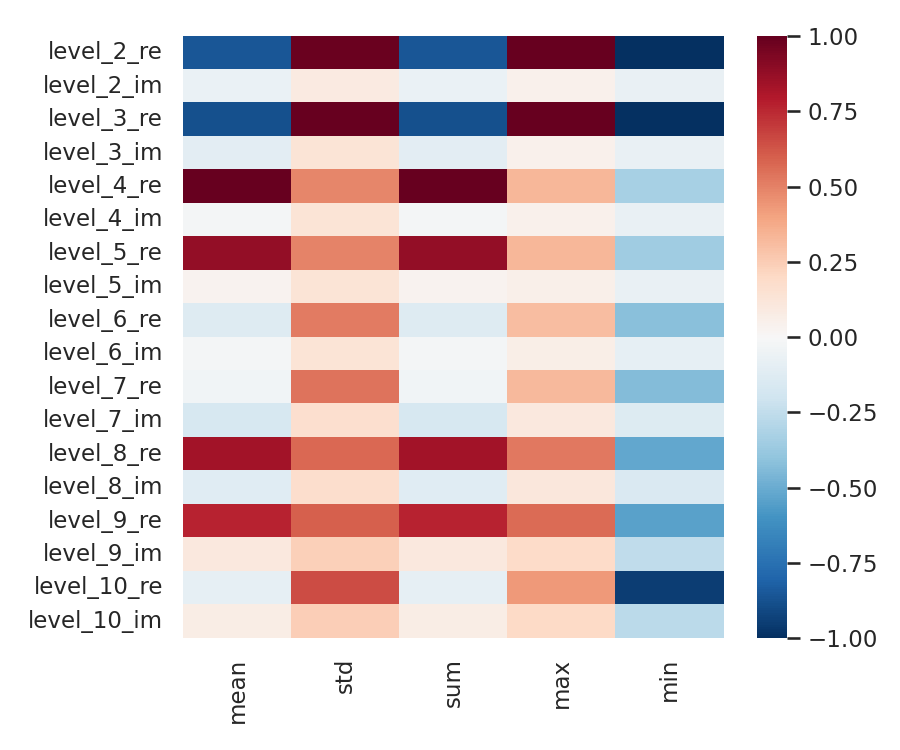

In [6]:
from IPython.display import Image
Image('./img/lev_summary_norm.png', width=480)

In [7]:
df_oth_summary = df_oth.agg({'max', 'min', 'sum', 'mean', 'std'})

# normalize the input over rows
df_oth_summary_norm = df_oth_summary.abs().max(axis=1)
df_oth_summary_norm = df_oth_summary.div(df_oth_summary_norm, axis='index')
df_oth_summary_norm.transpose().to_csv('./data/oth_summary_norm.csv')

df_oth_summary

,k,exp_re,exp_im,weight,j,m,type
mean,6.777381,0.038664,-0.001853,0.904315,1.971429,0.000000,3.890476
std,1.314858,0.594829,0.298647,0.588936,1.263905,1.576801,0.455165
sum,11386.000000,64.955998,-3.112788,1519.250000,3312.000000,0.000000,6536.000000
max,8.000000,1.414214,0.930605,2.000000,4.000000,4.000000,4.000000
min,2.000000,-1.519671,-0.930605,0.000000,0.000000,-4.000000,2.000000


In [8]:
!python3 ./scripts/heatmap.py --input './data/oth_summary_norm.csv' --output 'oth_summary_norm'

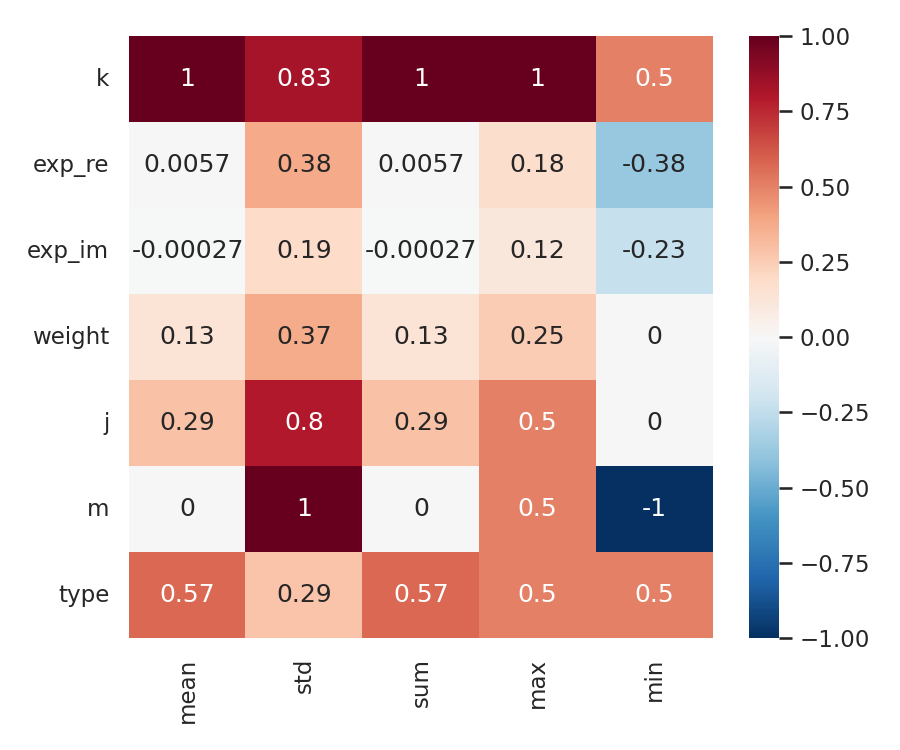

In [9]:
from IPython.display import Image
Image('./img/oth_summary_norm.png', width=480)

First thing we notice is that the sum of `m` is identically 0 and that even its average is vanishing.

We then remove the duplicated entries (they should present the same entries across all the columns):

In [10]:
duplicates = df.duplicated()

# drop the duplicates
df_dup = df.loc[duplicates]
df     = df.loc[~duplicates]

# save the new dataset (first order it for future comparisons)
df_dup.to_csv('./data/wzw_duplicates.csv', index=False)
df.to_csv('./data/wzw_eda.csv', index=False)

# compute the fraction of duplicates
print('Fraction of duplicated entries: {:.2f}%'.format(100 * duplicates.mean()))
print('Number of duplicates:           {:d}'.format(duplicates.sum()))

Fraction of duplicated entries: 1.96%
Number of duplicates:           33


We can also visualise the duplicate entries since they are not many:

In [11]:
df_dup

,k,exp_re,exp_im,weight,j,m,type,level_2_re,level_2_im,level_3_re,...,level_6_re,level_6_im,level_7_re,level_7_im,level_8_re,level_8_im,level_9_re,level_9_im,level_10_re,level_10_im
4,2.0,-0.707107,0.0,1.00000,0.0,0.0,4.0,-0.893387,0.0,-0.945626,...,-0.721123,0.0,-0.730309,0.0,-0.629844,0.0,-0.631591,0.0,-0.704802,0.0
50,4.0,0.000000,0.0,1.00000,0.0,0.0,4.0,-26.284377,0.0,-26.284377,...,-3.878629,0.0,-3.878629,0.0,0.347243,0.0,0.347243,0.0,-1.623628,0.0
96,5.0,0.297634,0.0,1.00000,0.0,0.0,4.0,-11.500361,0.0,-11.500361,...,-2.118758,0.0,-2.118758,0.0,0.500225,0.0,0.500225,0.0,-0.906838,0.0
155,6.0,0.437426,0.0,1.00000,0.0,0.0,4.0,-5.834252,0.0,-5.834252,...,-1.230187,0.0,-1.230187,0.0,0.573289,0.0,0.573289,0.0,-0.460420,0.0
229,7.0,0.500705,0.0,1.00000,0.0,0.0,4.0,-3.295494,0.0,-3.295494,...,-0.706085,0.0,-0.706085,0.0,0.599812,0.0,0.599812,0.0,-0.175215,0.0
320,8.0,0.525731,0.0,1.00000,0.0,0.0,4.0,-1.990131,0.0,-1.990131,...,-0.375981,0.0,-0.375981,0.0,0.601846,0.0,0.601846,0.0,0.009845,0.0
390,4.0,0.537285,0.0,1.00000,0.0,0.0,4.0,-2.076820,0.0,-2.402172,...,-1.437987,0.0,-1.474400,0.0,0.977158,0.0,1.041116,0.0,-0.944370,0.0
410,4.0,-0.537285,0.0,1.00000,0.0,0.0,4.0,-0.397915,0.0,-0.574472,...,-0.485408,0.0,-0.500585,0.0,-0.455752,0.0,-0.459780,0.0,-0.501793,0.0
430,5.0,-0.779215,0.0,1.00000,0.0,0.0,4.0,-0.633870,0.0,-0.879004,...,-0.842719,0.0,-0.876295,0.0,-0.596112,0.0,-0.594220,0.0,-0.831501,0.0
482,5.0,0.481581,0.0,1.00000,0.0,0.0,4.0,-1.547235,0.0,-1.809712,...,-1.037584,0.0,-1.091161,0.0,0.987751,0.0,1.062842,0.0,-0.679567,0.0


The new dataset has therefore a smaller number of entries and different properties:

In [12]:
df.describe()

,k,exp_re,exp_im,weight,j,m,type,level_2_re,level_2_im,level_3_re,...,level_6_re,level_6_im,level_7_re,level_7_im,level_8_re,level_8_im,level_9_re,level_9_im,level_10_re,level_10_im
count,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,...,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000,1647.000000
mean,6.784457,0.039473,-0.001890,0.904660,2.002429,0.000000,3.888282,-0.039372,-0.005783,-0.038920,...,0.002130,-0.002027,0.010572,-0.015218,0.073137,-0.011159,0.065939,0.009917,0.000521,0.006889
std,1.309949,0.596876,0.301625,0.594117,1.252577,1.587753,0.459439,2.536976,0.237263,2.571754,...,1.391057,0.372175,1.443925,0.448329,1.531316,0.476229,1.591242,0.629464,1.738222,0.663840
min,2.000000,-1.519671,-0.930605,0.000000,0.000000,-4.000000,2.000000,-26.284377,-1.867961,-26.284377,...,-10.978029,-2.287981,-11.445648,-3.646223,-13.721069,-4.023181,-14.249796,-6.650984,-24.994666,-7.174097
25%,6.000000,-0.441788,0.000000,0.375000,1.000000,-1.000000,4.000000,-0.558114,0.000000,-0.579659,...,-0.521596,0.000000,-0.530032,0.000000,-0.498717,0.000000,-0.486161,0.000000,-0.478383,0.000000
50%,7.000000,0.000000,0.000000,0.972222,2.000000,0.000000,4.000000,0.000476,0.000000,0.004674,...,0.000000,0.000000,0.000000,0.000000,0.009156,0.000000,0.006125,0.000000,0.000000,0.000000
75%,8.000000,0.506705,0.000000,1.333333,3.000000,1.000000,4.000000,0.600366,0.000000,0.633898,...,0.545093,0.000000,0.564691,0.000000,0.596880,0.000000,0.589068,0.000000,0.521422,0.000000
max,8.000000,1.414214,0.930605,2.000000,4.000000,4.000000,4.000000,35.385221,1.867961,35.385221,...,10.978029,2.287981,11.445648,3.646223,18.673134,4.023181,20.051284,6.683011,15.315423,7.187127


In [13]:
print('No. of rows:    {:d}'.format(df.shape[0]))
print('No. of columns: {:d}'.format(df.shape[1]))

No. of rows:    1647
No. of columns: 25


We can then check that the properties seen before do not change drastically after removing the outliers:

In [14]:
# divide into levels and other variables for visualisation
df_lev_nodup = df.filter(regex='^level_\d*_.*')
df_oth_nodup = df.filter(regex='^(?!level).*')

In [15]:
df_lev_nodup_summary = df_lev.agg({'max', 'min', 'sum', 'mean', 'std'})

# normalize the input over rows
df_lev_nodup_summary_norm = df_lev_nodup_summary.abs().max(axis=1)
df_lev_nodup_summary_norm = df_lev_nodup_summary.div(df_lev_nodup_summary_norm, axis='index')
df_lev_nodup_summary_norm.transpose().to_csv('./data/lev_nodup_summary_norm.csv')

df_lev_nodup_summary

,level_2_re,level_2_im,level_3_re,level_3_im,level_4_re,level_4_im,level_5_re,level_5_im,level_6_re,level_6_im,level_7_re,level_7_im,level_8_re,level_8_im,level_9_re,level_9_im,level_10_re,level_10_im
mean,-0.077024,-0.005670,-0.079294,-0.009452,0.089836,-0.001553,0.078986,0.003396,-0.011237,-0.001987,-0.003376,-0.014919,0.075769,-0.010940,0.069030,0.009722,-0.008013,0.006753
std,2.614227,0.234921,2.648262,0.371899,1.286826,0.352832,1.317507,0.353773,1.384471,0.368500,1.436868,0.443906,1.518934,0.471528,1.578406,0.623249,1.722916,0.657285
sum,-129.400279,-9.525292,-133.214652,-15.878558,150.924236,-2.608309,132.696033,5.705360,-18.877472,-3.338268,-5.671341,-25.063620,127.291377,-18.379071,115.970086,16.332544,-13.461804,11.345453
max,35.385221,1.867961,35.385221,1.736677,11.673646,1.930349,11.673646,2.005075,10.978029,2.287981,11.445648,3.646223,18.673134,4.023181,20.051284,6.683011,15.315423,7.187127
min,-26.284377,-1.867961,-26.284377,-1.969113,-8.757038,-1.930349,-9.252983,-2.005075,-10.978029,-2.287981,-11.445648,-3.646223,-13.721069,-4.023181,-14.249796,-6.650984,-24.994666,-7.174097


In [16]:
!python3 ./scripts/heatmap.py --input './data/lev_nodup_summary_norm.csv' --output 'lev_nodup_summary_norm'

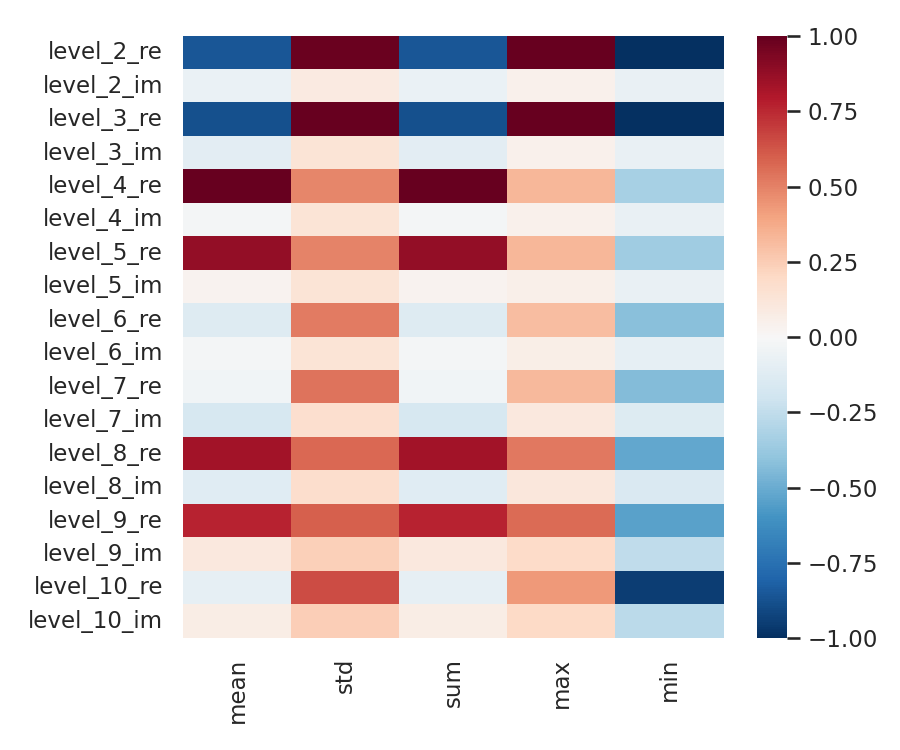

In [17]:
from IPython.display import Image
Image('./img/lev_nodup_summary_norm.png', width=480)

In [18]:
df_oth_nodup_summary = df_oth.agg({'max', 'min', 'sum', 'mean', 'std'})

# normalize the input over rows
df_oth_nodup_summary_norm = df_oth_nodup_summary.abs().max(axis=1)
df_oth_nodup_summary_norm = df_oth_nodup_summary.div(df_oth_nodup_summary_norm, axis='index')
df_oth_nodup_summary_norm.transpose().to_csv('./data/oth_nodup_summary_norm.csv')

df_oth_nodup_summary

,k,exp_re,exp_im,weight,j,m,type
mean,6.777381,0.038664,-0.001853,0.904315,1.971429,0.000000,3.890476
std,1.314858,0.594829,0.298647,0.588936,1.263905,1.576801,0.455165
sum,11386.000000,64.955998,-3.112788,1519.250000,3312.000000,0.000000,6536.000000
max,8.000000,1.414214,0.930605,2.000000,4.000000,4.000000,4.000000
min,2.000000,-1.519671,-0.930605,0.000000,0.000000,-4.000000,2.000000


In [19]:
!python3 ./scripts/heatmap.py --input './data/oth_nodup_summary_norm.csv' --output 'oth_nodup_summary_norm'

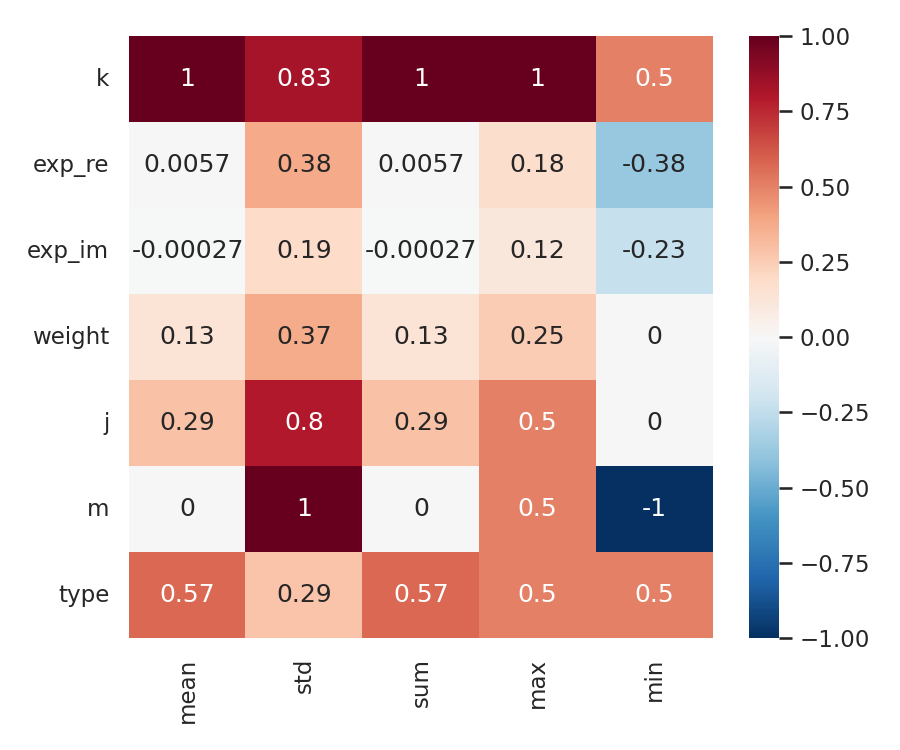

In [20]:
from IPython.display import Image
Image('./img/oth_nodup_summary_norm.png', width=480)

We can then study the outliers of the distributions of the variables (except the labels) to figure out how to deal with them:

In [21]:
import pandas as pd
import numpy  as np

def quartile(series: pd.Series) -> pd.Series:
    '''
    Return the logical array of samples outside the interquartile range.
    
    Required arguments:
        series: the Pandas series to consider.
        
    Returns:
        the logical array of outliers
    '''
    # compute the 25th and 75th percentile
    q1, q3 = series.quantile([0.25, 0.75])
    iqr    = q3 - q1
    
    # compute the lower and upper bounds of the interval
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    return (series < lower) | (series > upper)

In [22]:
# apply to dataset
df_quart = df.drop(columns=['exp_re', 'exp_im'])
df_quart = df_quart.apply(quartile, axis=0)
df_quart = df_quart.apply(lambda x: round(np.mean(x), 2), axis=0)
df_quart

k              0.01
weight         0.00
j              0.00
m              0.00
type           0.06
level_2_re     0.07
level_2_im     0.29
level_3_re     0.09
level_3_im     0.38
level_4_re     0.06
level_4_im     0.38
level_5_re     0.06
level_5_im     0.38
level_6_re     0.07
level_6_im     0.38
level_7_re     0.06
level_7_im     0.38
level_8_re     0.05
level_8_im     0.38
level_9_re     0.05
level_9_im     0.38
level_10_re    0.06
level_10_im    0.38
dtype: float64

In general it seems that the number of outliers is very restricted for the real part of the variables. The imaginary parts have many more of them, but if may be caused by the fact that they take values only in a defined set (or the fact that they are not independent).

We can visualise the distribution of the variables in histograms:

In [23]:
!python3 ./scripts/df-distrib.py --input './data/wzw_eda.csv' --output 'var_distr' --rows 5 --columns 5

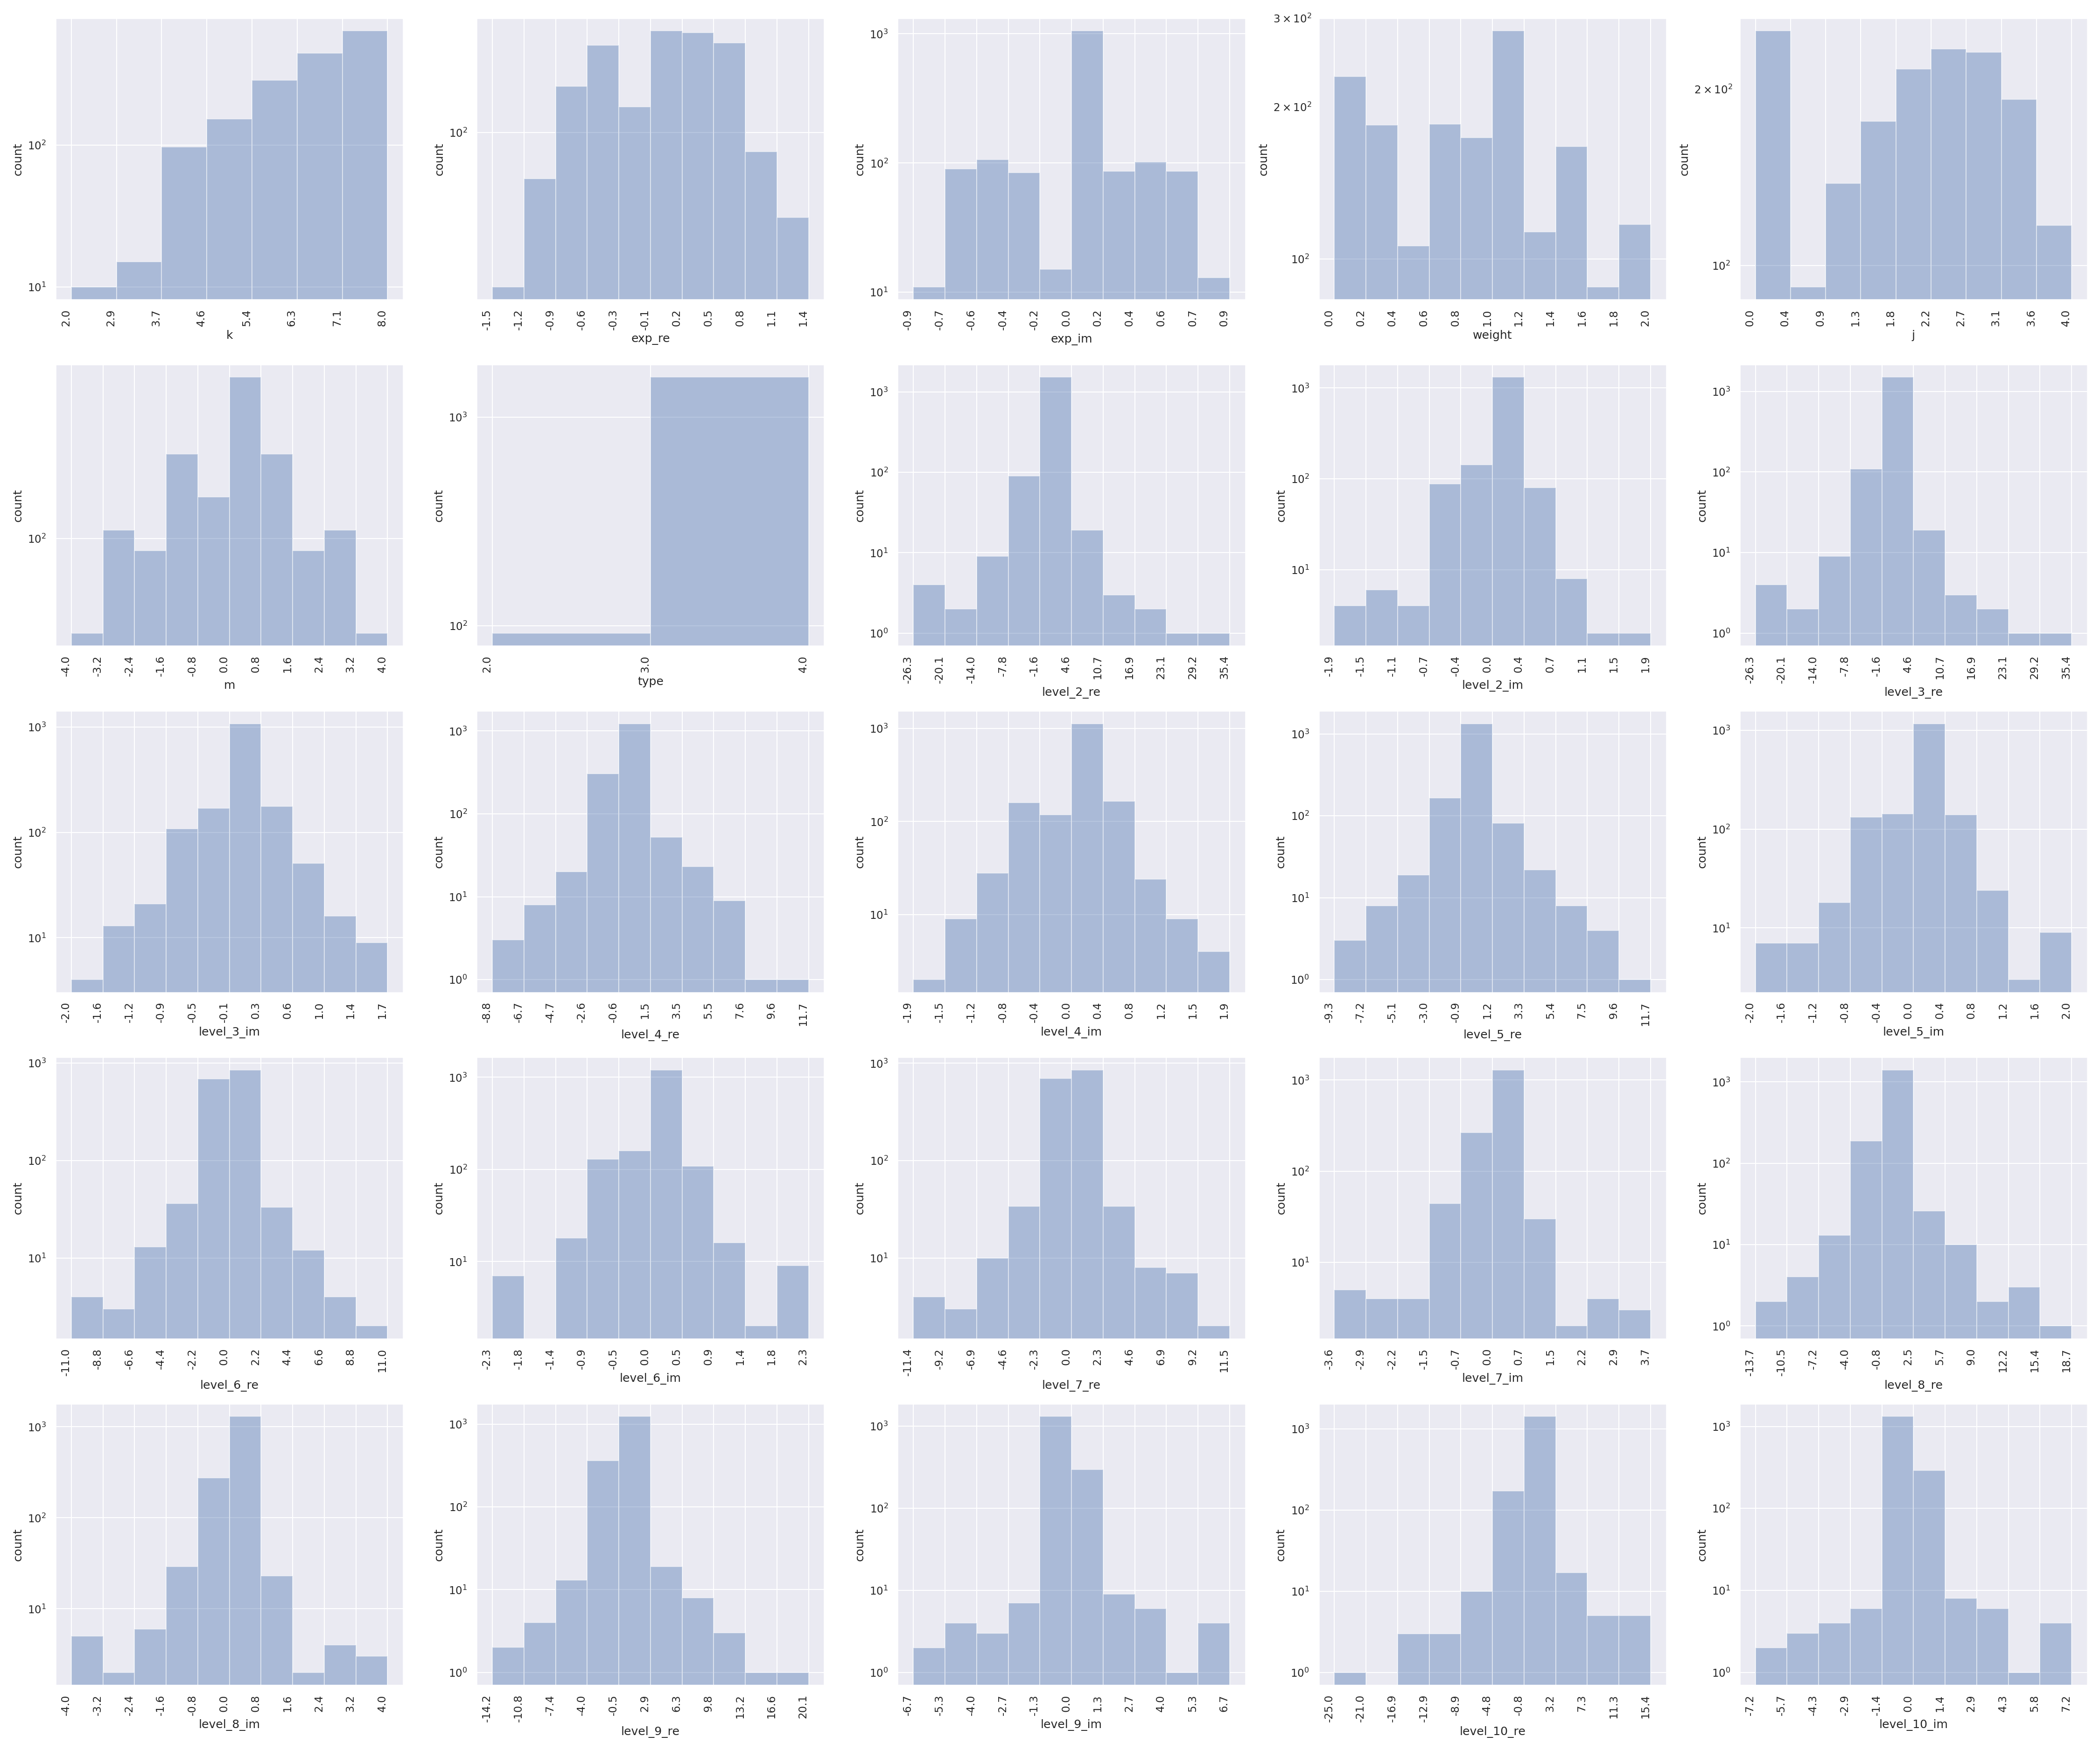

In [24]:
from IPython.display import Image
Image('./img/var_distr.png', width=480)

The same plot can be produced considering the distribution of the features according to the different orders of magnitudes to better understand the distribution of the variables:

In [25]:
!python3 ./scripts/df-counts.py --input './data/wzw_eda.csv' --output 'var_counts' --rows 5 --columns 5

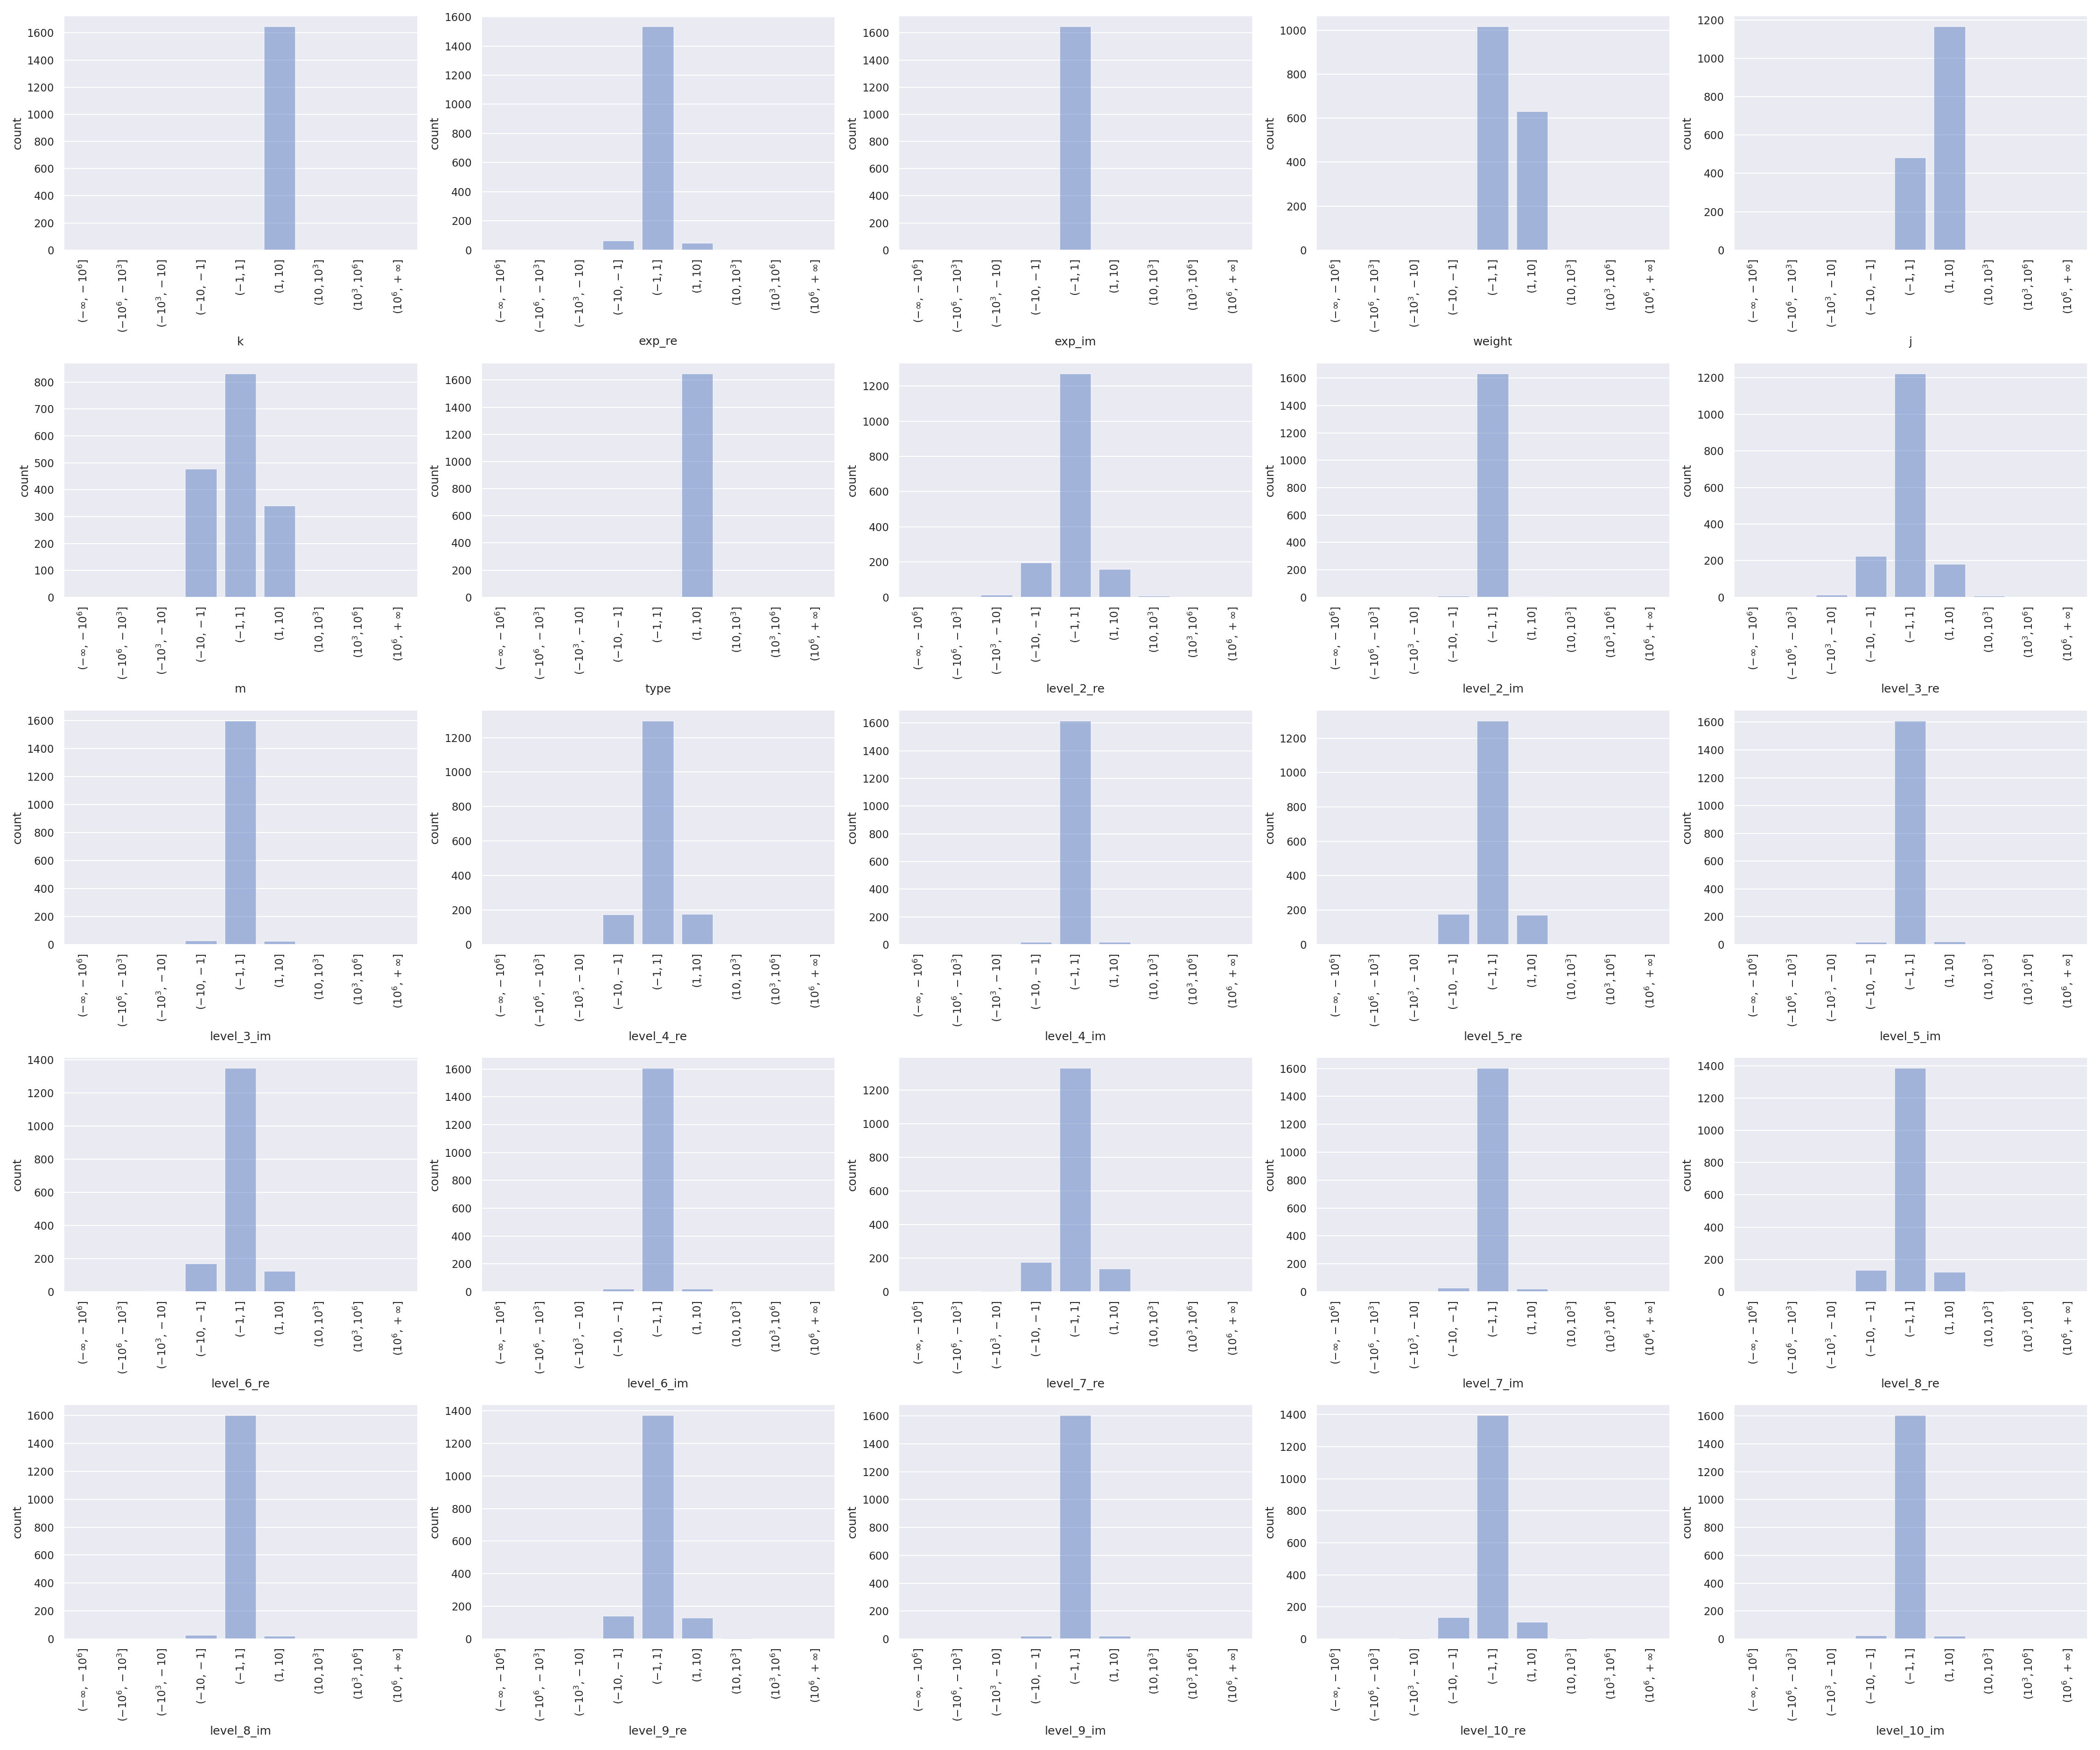

In [26]:
from IPython.display import Image
Image('./img/var_counts.png', width=480)

The distributions are in fact quite restricted and do not present high numbers of samples in the tails. This should in turn facilitate the ML analysis.

This is also supported by looking at the box plot of the variables:

In [27]:
!python3 ./scripts/df-boxplot.py --input './data/wzw_eda.csv' --output 'var_box'

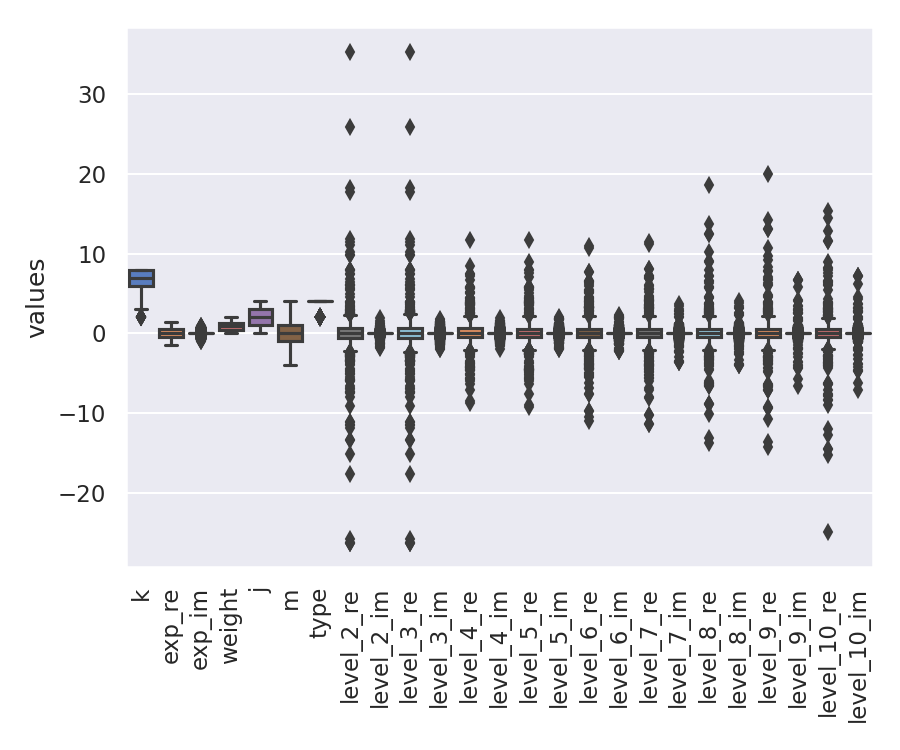

In [28]:
from IPython.display import Image
Image('./img/var_box.png', width=480)

Though it may seem that the real part of the variables have a larger number of outliers, they are simply more spread than their imaginary counterparts. As supposed earlier, the large number of outliers in the imaginary parts is mainly due to the fact that their distributions are extremely peaked at a certain values ($0$ in this case). In fact the visualisation of the truncation levels separated into real and imaginary parts should support this:

In [29]:
df_re = df.filter(regex='.*_re$').drop(columns=['exp_re'])
df_im = df.filter(regex='.*_im$').drop(columns=['exp_im'])

df_re.to_csv('./data/wzw_re_box.csv', index=False)
df_im.to_csv('./data/wzw_im_box.csv', index=False)

In [30]:
!python3 ./scripts/df-boxplot.py --input './data/wzw_re_box.csv' --output 'var_box_re'

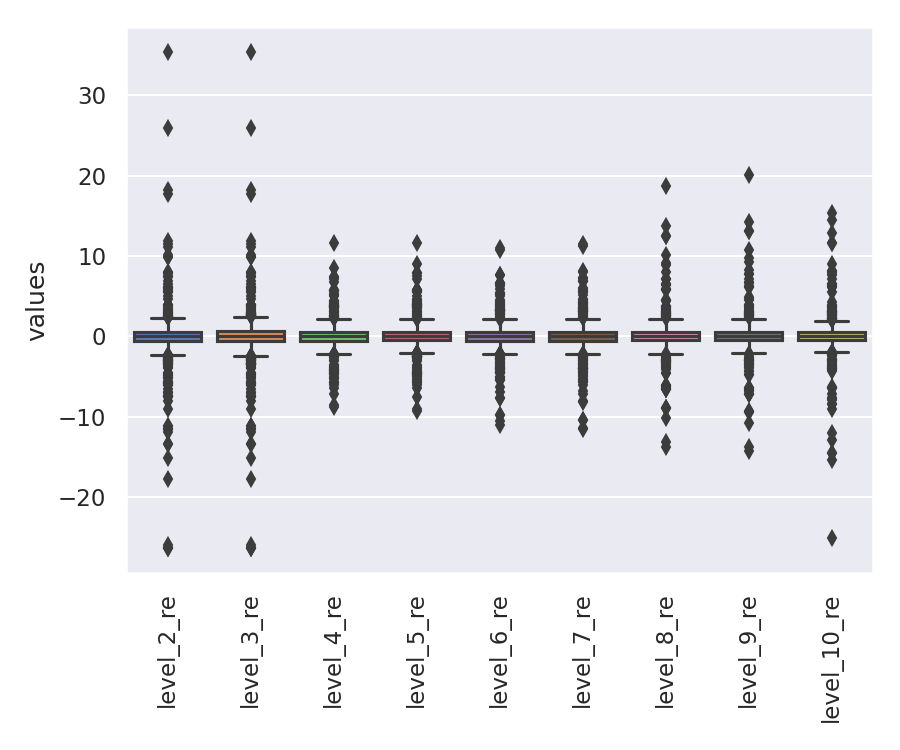

In [31]:
from IPython.display import Image
Image('./img/var_box_re.png', width=480)

In [32]:
!python3 ./scripts/df-boxplot.py --input './data/wzw_im_box.csv' --output 'var_box_im'

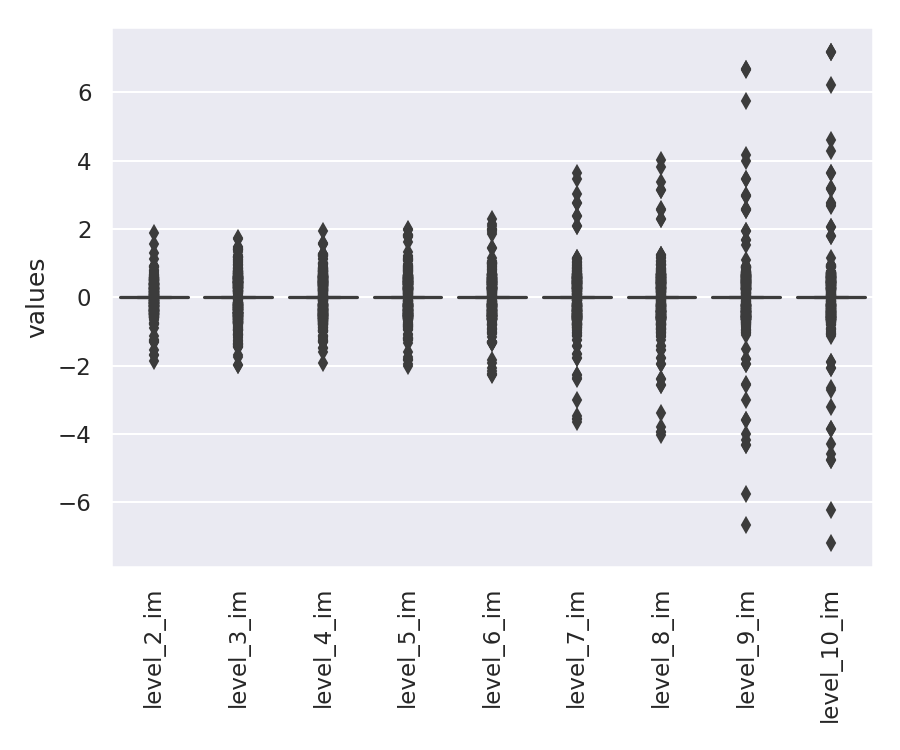

In [33]:
from IPython.display import Image
Image('./img/var_box_im.png', width=480)

We then explore the different relations between the data at different weights:

In [34]:
df_bin = df[['weight', 'type', 'j', 'm', 'k']].copy()
df_bin['weight_bin'] = pd.Categorical((df_bin['weight'] < 1.0).astype(int)).\
                          rename_categories(['≥ 1.0', '< 1.0'])

# group by category
df_bin.groupby(['weight_bin', 'type', 'k']).agg({'weight': ['mean', 'var'],
                                                 'j': ['mean', 'var'],
                                                 'm': ['mean', 'var']
                                                }
                                               )

weight                   j              m          
                         mean       var      mean       var mean       var
weight_bin type k                                                         
≥ 1.0      2.0  2.0       NaN       NaN       NaN       NaN  NaN       NaN
                3.0       NaN       NaN       NaN       NaN  NaN       NaN
                4.0       NaN       NaN       NaN       NaN  NaN       NaN
                5.0       NaN       NaN       NaN       NaN  NaN       NaN
                6.0       NaN       NaN       NaN       NaN  NaN       NaN
                7.0       NaN       NaN       NaN       NaN  NaN       NaN
                8.0       NaN       NaN       NaN       NaN  NaN       NaN
           4.0  2.0  1.000000  0.000000  0.000000  0.000000  0.0  0.000000
                3.0  1.000000  0.000000  0.000000  0.000000  0.0  0.000000
                4.0  1.000000  0.000000  1.351351  0.900901  0.0  1.388889
                5.0  1.176471  0.013235  1.764706  1.323529  0.0  2.100000
                6.0  1.264946  0.047719  2.347826  1.049667  0.0  2.989051
                7.0  1.474957  0.075614  2.792746  1.383905  0.0  4.010417
                8.0  1.566860  0.129700  3.212209  1.211396  0.0  4.927114
< 1.0      2.0  2.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
                3.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
                4.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
                5.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
                6.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
                7.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
                8.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000
           4.0  2.0  0.312500  0.046875  0.666667  0.166667  0.0  0.500000
                3.0  0.450000  0.083333  1.000000  0.277778  0.0  0.833333
                4.0  0.375000  0.053146  1.000000  0.255102  0.0  0.765306
                5.0  0.500000  0.090289  1.333333  0.393258  0.0  1.179775
                6.0  0.436546  0.070958  1.328244  0.402965  0.0  1.142308
                7.0  0.555556  0.108494  1.666667  0.557971  0.0  1.673913
                8.0  0.498513  0.088981  1.661710  0.564237  0.0  1.638060

From the table we see that:

- `weight` $\ge 1.0$ and `type` $= 2$ does not exist,
- `weight` $\ge 1.0$ and `type` $= 4$ and `k` $= 2,\,3$ $\Rightarrow$ `weight` $\equiv 1$ and `j` $\equiv 0$ and `m` $\equiv 0$,
- `weight` $\ge 1.0$ and `type` $= 4$ and `k` $= 4$ $\Rightarrow$ `weight` $\equiv 1$,
- `weight` $< 1.0$ and `type` $= 2$ $\Rightarrow$ `weight` $\equiv 0$ and `j` $\equiv 0$ and `m` $\equiv 0$.

Finally we show the correlation matrices of the variables in the dataset:

In [35]:
corr = df.corr()
corr.to_csv('./data/corr.csv')

# display the correlation matrix
!python3 ./scripts/heatmap.py --input './data/corr.csv' --output 'mat_corr'

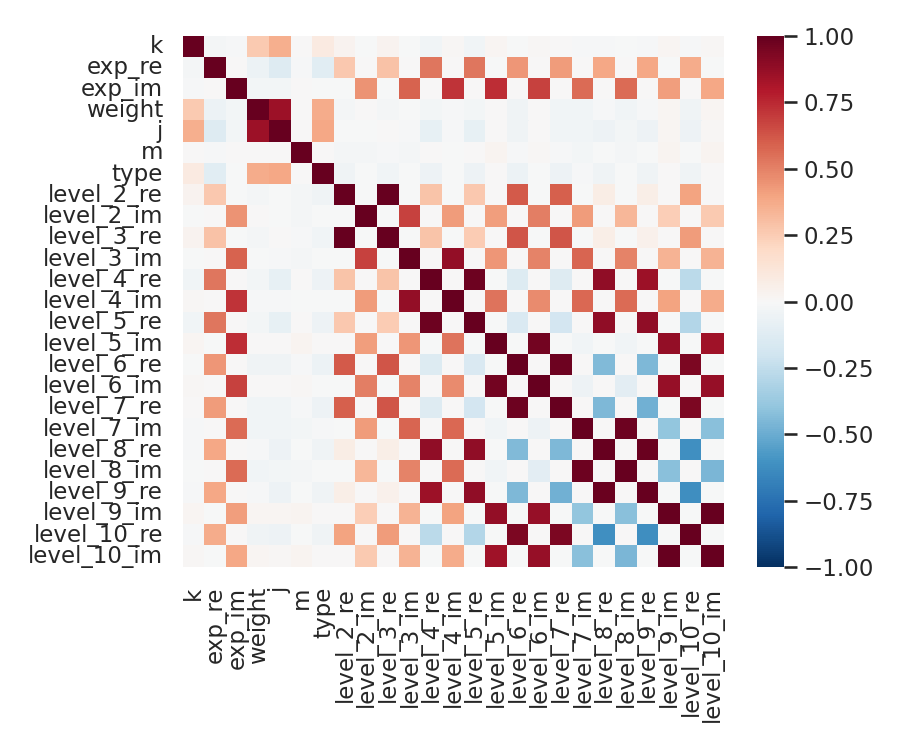

In [36]:
from IPython.display import Image
Image('./img/mat_corr.png', width=480)

Most correlations seem to be related to the truncation levels where the real and imaginary parts are separately correlated among themselves.